In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
df = pd.read_csv("sPlotOpen_DT(1).txt", delimiter="\t")
df.head()

,PlotObservationID,Species,Original_species,Original_abundance,Abundance_scale,Relative_cover
0,16,Festuca brachyphylla,Festuca brachyphylla,10.0,CoverPerc,0.277778
1,16,Potentilla elegans,Potentilla elegans,25.0,CoverPerc,0.694444
2,16,Saxifraga serpyllifolia,Saxifraga serpyllifolia,1.0,CoverPerc,0.027778
3,17,Festuca brachyphylla,Festuca brachyphylla,1.0,CoverPerc,0.038462
4,17,Potentilla elegans,Potentilla elegans,25.0,CoverPerc,0.961538


Number of plots: 94863
Number of species (with >20 observations): 12766


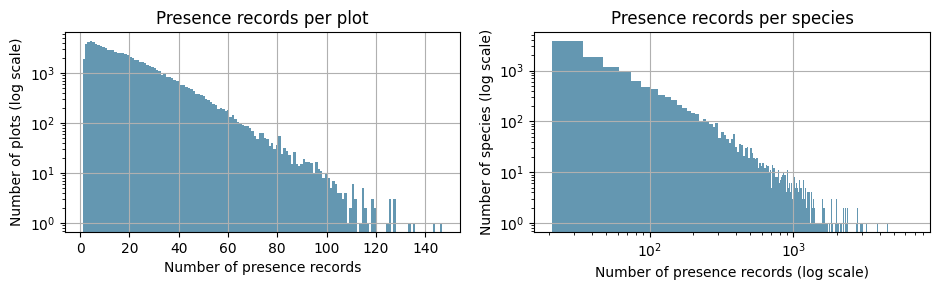

In [3]:
species_counts = df["Species"].value_counts()

filtered_species = species_counts[species_counts > 20].index
df_filtered = df[df["Species"].isin(filtered_species)]

num_plots = len(df_filtered["PlotObservationID"].unique())
print(f"Number of plots: {num_plots}")

num_species = len(df_filtered["Species"].unique())
print(f"Number of species (with >20 observations): {num_species}")

color = "#6497B1"

fig, axs = plt.subplots(1, 2, figsize=(9.5, 3))

df_filtered.groupby("PlotObservationID").size().sort_values(ascending=False).hist(
    bins=147, log=True, ax=axs[0], color=color
)
axs[0].set_title("Presence records per plot")
axs[0].set_xlabel("Number of presence records")
axs[0].set_ylabel("Number of plots (log scale)")

# Plot for number of records per species (log scale for x-axis)
df_filtered.groupby("Species").size().sort_values(ascending=False).hist(
    bins=500, log=True, ax=axs[1], color=color
)
axs[1].set_title("Presence records per species")
axs[1].set_xlabel("Number of presence records (log scale)")
axs[1].set_ylabel("Number of species (log scale)")
axs[1].set_xscale("log")

plt.tight_layout()
plt.savefig("../figures/species_distribution.pdf", bbox_inches='tight')
plt.show()

In [4]:
species_list = df["Species"].unique()
num_species = len(df["Species"].unique())
species_list

for i, species in enumerate(species_list):
    if type(species) != str:
        nan_index = i

species_list = np.delete(species_list, nan_index)
species_list = np.sort(species_list)
species2ind = {species: i for i, species in enumerate(species_list)}

pd.DataFrame(list(species2ind.items()), columns=['Species Name', 'Index']).to_csv("species_names.csv", index=False)

In [5]:
grouped = df.groupby('PlotObservationID').aggregate({'Species': list})

grouped['Species'] = grouped['Species'].apply(lambda x: [species2ind[species] for species in x if not pd.isna(species)])
site2ind = {site: i for i, site in enumerate(grouped.index.values.tolist())}
ind2site = {i: site for i, site in enumerate(grouped.index.values.tolist())}

mlb = MultiLabelBinarizer()
species_encoded = mlb.fit_transform(grouped['Species'])
print(species_encoded.shape)

(95104, 42679)


In [6]:
# Save species_occurrences file
np.save("species_occurrences.npy", species_encoded.astype(bool))